In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pysindy as ps
from IPython.display import Video,display
import os

In [2]:
#If the new PDELibrary arguments function_library causes errors, you need to install a newer version from https://github.com/dynamicslab/pysindy
#my version is 1.7.6.dev464+g0d47d7a
ps.__version__

'1.7.6.dev464+g0d47d7a'

# Test weak form PDE functionality on Reaction-Diffusion system
We consider the reaction-diffusion system
$$U_t = 0.1\nabla^2 U + (1 - U^2 - V^2)U +\beta (U^2 + V^2)V,$$
$$V_t = 0.1\nabla^2 V - \beta (U^2 + V^2) U + (1 - U^2 - V^2)V,$$
with inhomogeneous and time-varying parameter 
$$\beta = 1+\sin(2\pi x/L)\sin(2\pi y/L)\sin(2\pi t/10).$$
We treat $\beta$ as a control signal and use a weak library.

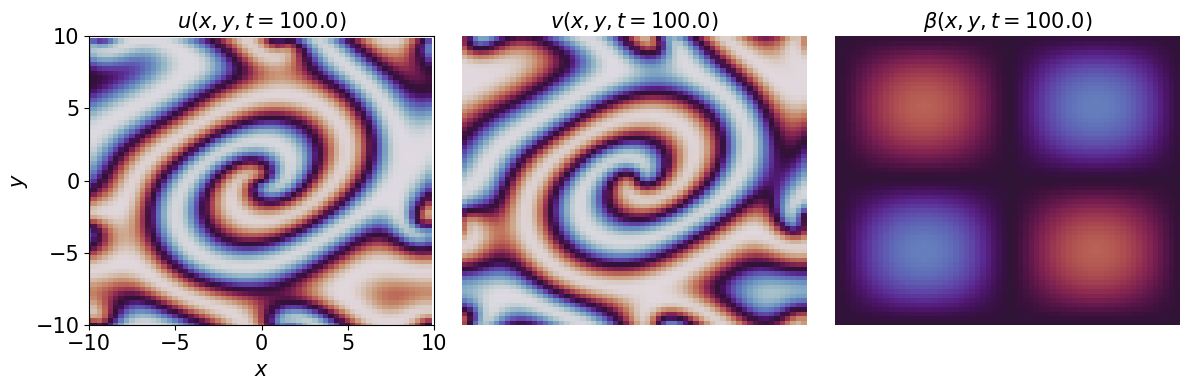

In [3]:
# Generate the data
T=100
nt=1000
t = np.linspace(0, T, nt)
omega=2*np.pi/10
d1 = 0.1
d2 = 0.1
beta0 = 1.0 
deltabeta = 1.0
L = 20  # Domain size in X and Y directions
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n//2 - 1, n//2), np.linspace(-n//2, -1, n//2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
x_grid, y_grid = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2

def beta_func(x,y,t, beta0, deltabeta):
    return beta0 + deltabeta*np.sin(2*np.pi*x/L)*np.sin(2*np.pi*y/L)*np.sin(omega*t)

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uv, K2, d1, d2, beta0, deltabeta, n, N):
    beta = beta_func(x_grid,y_grid,t,beta0,deltabeta)
    u = np.reshape(uv[:N], (n, n))
    v = np.reshape(uv[N:], (n, n))
    u3 = u**3; v3 = v**3
    u2v = (u**2) * v; uv2 = u * (v**2)
    urhs = u - u3 - uv2 + beta * u2v + beta * v3
    vrhs = v - u2v - v3 - beta * u3 - beta * uv2
    u_diffuse = np.real(np.fft.ifft2(-d1 * K2 * np.fft.fft2(u)))
    v_diffuse = np.real(np.fft.ifft2(-d2 * K2 * np.fft.fft2(v)))
    
    return np.concatenate([(u_diffuse + urhs).reshape(N), (v_diffuse + vrhs).reshape(N)])


# define our solution vectors
U = np.zeros((len(x), len(y), len(t))) 
V = np.zeros((len(x), len(y), len(t))) 

# Initial conditions
m = 1  # number of spirals
U[:, :, 0] = np.tanh(np.sqrt(x_grid**2 + y_grid**2)) * np.cos(
    m * np.angle(x_grid + 1j * y_grid) - (np.sqrt(x_grid**2 + y_grid**2))
)
V[:, :, 0] = np.tanh(np.sqrt(x_grid**2 + y_grid**2)) * np.sin(
    m * np.angle(x_grid + 1j * y_grid) - (np.sqrt(x_grid**2 + y_grid**2))
)
UV0 = np.concatenate([U[:,:,0].reshape(N),V[:,:,0].reshape(N)])

# Solve the PDE with pseudospectral method
UVsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=UV0, t_eval=t, args=(K2, d1, d2, beta0, deltabeta, n, N))

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
U=UVsol.y[:N].reshape((n,n,len(t)))
V=UVsol.y[N:].reshape((n,n,len(t)))
Beta=beta_func(x_grid[:,:,np.newaxis],y_grid[:,:,np.newaxis],t[np.newaxis,np.newaxis,:],beta0,deltabeta)

# Plot to check if spiral is nicely reproduced
uclims=(np.min(U),np.max(U))
vclims=(np.min(V),np.max(V))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.pcolor(x, y, U[:, :, -10],cmap='twilight')
plt.clim(*uclims)
#plt.colorbar()
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$y$", fontsize=15)
plt.title("$u(x, y, t=%.1f)$"%t[-1], fontsize=15)
plt.xlim([-10,10])
plt.xticks([-10, -5, 0, 5, 10], fontsize=15)
plt.ylim([-10,10])
plt.yticks([-10, -5, 0, 5, 10], fontsize=15)

plt.subplot(1, 3, 2)
plt.pcolor(x, y, V[:, :, -10],cmap='twilight')
plt.clim(*vclims)
#plt.colorbar()
#plt.xlabel("$x$", fontsize=1)
#plt.title("$v(x, y, t=%.1f)$"%t[-1], fontsize=15)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("$v(x, y, t=%.1f)$"%t[-1], fontsize=15)
ax.axis('off')
plt.subplot(1, 3, 3)
plt.pcolor(x, y, Beta[:, :, -10],cmap='twilight')
plt.clim(0,2)
#plt.colorbar()
plt.xlabel("$x$", fontsize=1)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\beta(x, y, t=%.1f)$"%t[-1], fontsize=15)
ax.axis('off')
plt.tight_layout()

plt.savefig('pdefind_RD.eps', format='eps')
plt.show()



The initial condition is not periodic but we use a periodic pseudospectral method, so there are some boundary artifacts. Let's trim the data and add some noise (standard deviation is 5% of the mean value of U and V).

In [4]:
trimx=5
trimy=5
trimt=100
X = np.zeros((n-2*trimx, n-2*trimy, len(t)-trimt, 2))
u = np.zeros((n-2*trimx, n-2*trimy, len(t)-trimt, 1))

X[:, :, :, 0] = U[trimx:-trimx,trimy:-trimy,trimt:]
X[:, :, :, 1] = V[trimx:-trimx,trimy:-trimy,trimt:]
X = X + np.random.normal(0,np.mean(X**2)**0.5/20,size=X.shape)
u[:, :, :, 0] = Beta[trimx:-trimx,trimy:-trimy,trimt:]
spatiotemporal_grid = np.transpose(np.meshgrid(x, y, t, indexing="ij"), [1, 2, 3, 0])[trimx:-trimx,trimy:-trimy,trimt:]

Quite a good fit with a quartic weak feature library with spatial derivatives up to second order. A couple small extra terms that could probably be eliminated with more data/hyperparameter tuning.

In [5]:
np.random.seed(100)
weak_feature_lib = ps.WeakPDELibrary(
    function_library=ps.PolynomialLibrary(degree=4,include_bias=False),
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    H_xt=[dx*5,dx*5,dt*5],
    K=1000,
    include_interaction=False,
)
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-8, normalize_columns=False)
model = ps.SINDy(feature_library=weak_feature_lib, optimizer=optimizer, feature_names=['u','v','beta'])
model.fit(X,u=u,t=t[trimt:])
model.print()
model.score(X,u=u,t=t[trimt:])

(u)' = 0.900 u + 0.084 v + -0.059 beta + -0.066 u^2 + -0.114 u v + -0.158 v^2 + 0.077 beta^2 + -0.893 u^3 + -0.085 u^2 v + 0.153 u^2 beta + -0.901 u v^2 + -0.090 v^3 + 0.126 v^2 beta + 0.138 u^3 v + 0.989 u^2 v beta + -0.090 u^2 beta^2 + 0.123 u v^3 + 0.117 v^4 + 0.994 v^3 beta + -0.083 v^2 beta^2 + 0.088 u_22 + -152204297777.163 beta_22 + 0.091 u_11 + 152204297777.802 beta_11
(v)' = 0.835 v + -0.100 u beta + -0.829 u^2 v + -0.822 v^3 + -0.884 u^3 beta + -0.887 u v^2 beta + 0.088 v_22 + 0.091 v_11


0.9993317157271129

Fancy animation. The blurriness in the first two panels is because of the injected noise.

In [6]:
import os
if not os.path.exists('movie'):
    os.mkdir('movie')
else:
    os.system('rm movie/*')
uclims=(np.min(U),np.max(U))
vclims=(np.min(V),np.max(V))
for i in range(len(t[trimt:])):
    print('%03d of %i'%(i,len(t[trimt:])),end='\r')
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.pcolor(spatiotemporal_grid[:,:,0,0], spatiotemporal_grid[:,:,0,1], X[:, :, i, 0],cmap='twilight')
    plt.clim(*uclims)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("$u(x, y, t=%.1f)$"%t[trimt:][i])
    plt.subplot(1, 3, 2)
    plt.pcolor(spatiotemporal_grid[:,:,0,0], spatiotemporal_grid[:,:,0,1], X[:, :, i, 1],cmap='twilight')
    plt.clim(*vclims)
    plt.colorbar()
    plt.xlabel("$x$")
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title("$v(x, y, t=%.1f)$"%t[trimt:][i])
    plt.subplot(1, 3, 3)
    plt.pcolor(spatiotemporal_grid[:,:,0,0], spatiotemporal_grid[:,:,0,1], u[:, :, i, 0],cmap='twilight')
    plt.clim(0,2)
    plt.colorbar()
    plt.xlabel("$x$")
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r"$\beta(x, y, t=%.1f)$"%t[trimt:][i])
    plt.tight_layout()
    plt.savefig('movie/%03i.png'%i,dpi=100)
    plt.close('all')
os.system('ffmpeg -y -r 15 -i movie/%03d.png -c:v libopenh264 -crf 1 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2,format=yuv420p" movie.mp4')
os.system('rm movie/*')
display(Video('movie.mp4',width=1024))

sh: ffmpeg: command not found


ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')